<p align = "center" >
    <img src = '../../docs/logo.png' height = "200">
<p>


## Implementation of the DLT camera calibration algorithm

In [28]:
# Import librarys
import time
from math import atan, pi
import numpy as np
import cv2
import random
import glob
import matplotlib.pyplot as plt
from scipy.linalg import svd, rq
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

## Coppelia Scene config

In [29]:

# Connect and configure the simulation 
client = RemoteAPIClient()
sim = client.getObject('sim')

# When simulation is not running, ZMQ message handling could be a bit
# slow, since the idle loop runs at 8 Hz by default. So let's make
# sure that the idle loop runs at full speed for this program:
defaultIdleFps = sim.getInt32Param(sim.intparam_idle_fps)   
sim.setInt32Param(sim.intparam_idle_fps, 0)

# Get the vision sensor handle
visionSensorHandle = sim.getObject('/Vision_sensor')
cubo = sim.getObject('/Cuboid[3]')

### Recover parameters from scene

In [30]:
def get_perspective_angle(focal_length, sensor_size):
    perspective_angle = 2*atan(sensor_size / (2*focal_length))
    perspective_angle = perspective_angle*(180/pi)
    print(perspective_angle)
    return perspective_angle

In [60]:
focal_length = 3.04
sensor_size = 3.68
perspective_angle = get_perspective_angle(focal_length,sensor_size)

image_size = (1280,720) # Defined in vision sensor parameters

pixel_density = (830,829) #Defined by the sensor resolution

# Create K matrix 
k_matrix = np.array([[focal_length, 0, image_size[0]/2],
                    [0, focal_length, image_size[1]/2],
                    [0, 0, 1]], dtype=np.float64)

sim.startSimulation()  # Start simulation in CoppeliaSim

# Get Vision_sensor transformation matrix (R and t related to world coordinate frame)
transformation_matrix = sim.getObjectMatrix(visionSensorHandle, -1)
transformation_matrix = np.array(transformation_matrix).reshape(3,4)

sim.stopSimulation() #Stop simulation in CoppeliaSim

rotation_matrix = transformation_matrix[:,:3]
translation_vector = transformation_matrix[:,3:]

# Create camera matrix C
camera_matrix_original = k_matrix @ transformation_matrix
print("The camera matrix is: \n",camera_matrix_original)

62.369949317476774
The camera matrix is: 
 [[-3.04000000e+00  6.40000000e+02  6.55938407e-11  4.20010712e+02]
 [-2.98454016e-10  3.60000000e+02  3.04000000e+00  2.32897085e+02]
 [-8.27292428e-13  1.00000000e+00  1.03472786e-13  6.58429641e-01]]


### Extract world points

In [32]:
# Visible points in calibration object, a cube with 30 cm width

world_points = np.array([[0.,2.,0.], #
                        [1.,0.,0.], #
                        [2.,0.,0.], #
                        [3.,0.,0.], #
                        [0.,3.,1.], #
                        [0.,2.,1.], #
                        [0.,1.,1.], #
                        [1.,0.,1.], #
                        [2.,0.,1.], #
                        [3.,0.,1.], #
                        [0.,3.,2.], #
                        [0.,2.,2.], #
                        [0.,1.,2.], #
                        [1.,0.,2.], #
                        [2.,0.,2.], #
                        [3.,0.,2.], #
                        [0.,3.,3.], #
                        [0.,2.,3.], #
                        [0.,1.,3.], #
                        [1.,0.,3.], # 
                        [2.,0.,3.], #
                        [3.,0.,3.], #
                        [1.,1.,3.], #
                        [2.,3.,3.], # 
                        [2.,2.,3.], #
                        [2.,1.,3.], #
                        [3.,2.,3.]])#

### Load the calibration images

In [33]:
image = cv2.imread('../../calibration-images/cube/image1.jpg') 

### Extract image points

number of corners detected:  27
[[[564.3152  252.68439]]

 [[694.6928  243.68637]]

 [[826.42706 233.55133]]

 [[625.03827 261.8383 ]]

 [[573.5912  340.64044]]

 [[883.82324 385.4333 ]]

 [[530.44305 407.4186 ]]

 [[640.3677  443.95663]]

 [[589.8389  503.97058]]

 [[759.52905 226.50145]]

 [[834.59064 490.49197]]

 [[640.3723  214.56644]]

 [[772.36536 436.53787]]

 [[882.011   217.62466]]

 [[632.4177  355.56662]]

 [[762.4857  252.42708]]

 [[582.48773 424.63785]]

 [[695.0399  220.20595]]

 [[829.6393  323.54968]]

 [[746.915   206.28847]]

 [[768.48425 346.7792 ]]

 [[777.3517  521.30194]]

 [[831.4153  409.56305]]

 [[510.4737  245.18546]]

 [[521.0537  327.31122]]

 [[883.33    303.22266]]

 [[886.38837 462.90256]]]


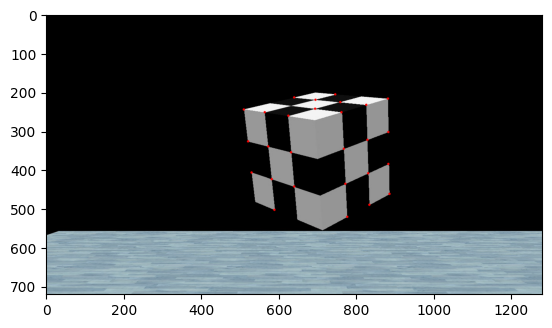

(<matplotlib.image.AxesImage at 0x7f534e9f1e50>, None)

In [34]:
# convert image to gray scale image 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    
# detect corners with the goodFeaturesToTrack function. 
corners = cv2.goodFeaturesToTrack(gray, 27, 0.01, 10) 
    
print("number of corners detected: ",corners.shape[0])
    
# Set the needed parameters to find the refined corners
winSize = (5, 5)
zeroZone = (-1, -1)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_COUNT, 40, 0.001)
# Calculate the refined corner locations
corners = cv2.cornerSubPix(gray, corners, winSize, zeroZone, criteria)

print(corners)

# we iterate through each corner,  
# making a circle at each point that we think is a corner. 
corners = np.intp(corners) 
for i in corners: 
    x, y = i.ravel()
    cv2.circle(image, (x, y), 3, 255, -1) 
    
plt.imshow(image), plt.show() 

In [35]:
# For my implementation, the image corners are: 
image_points =   np.array([[589.8389, 503.97058],
                          [777.3517,  521.30194],
                          [834.59064, 490.49197],
                          [886.38837, 462.90256],
                          [530.44305, 407.4186],
                          [582.48773, 424.63785],
                          [640.3677,  443.95663],
                          [772.36536, 436.53787],
                          [831.4153,  409.56305],
                          [883.82324, 385.4333],
                          [521.0537,  327.31122],
                          [573.5912, 340.64044],
                          [632.4177,  355.56662],
                          [768.48425, 346.7792],
                          [829.6393,  323.54968],
                          [883.33,    303.22266],
                          [510.4737,  245.18546],
                          [564.3152,  252.68439],
                          [625.03827, 261.8383 ],
                          [762.4857,  252.42708],
                          [826.42706, 233.55133],
                          [882.011,   217.62466],
                          [694.6928,  243.68637],
                          [640.3723,  214.56644],
                          [695.0399,  220.20595],
                          [759.52905, 226.50145],
                          [746.915,   206.28847]])

### Normalize points

In [ ]:
def normalize_points(points):
# Verifica se a matriz já tem 3 colunas (coordenadas homogêneas)
    if points.shape[1] == 3:
        # Adiciona uma coluna de 1's para manter a consistência com o processo abaixo
        points_homogeneous = np.hstack((points, np.ones((len(points), 1))))
    else:
        # Adiciona uma coluna de 1's para criar coordenadas homogêneas
        points_homogeneous = np.hstack((points, np.ones((len(points), 1))))

    # Calcula a média e a escala para normalização
    mean = np.mean(points_homogeneous, axis=0)
    scale = np.sqrt(2) / np.mean(np.linalg.norm(points_homogeneous - mean, axis=1))

    # Matriz de transformação
    T = np.array([[scale, 0, -scale * mean[0]],
                  [0, scale, -scale * mean[1]],
                  [0, 0, 1]])

    # Normaliza os pontos
    normalized_points = np.dot(T, points_homogeneous.T).T[:, :2]

    return normalized_points, T

world_points_normalized, T_world = normalize_points(world_points)
image_points_normalized, T_image = normalize_points(image_points)

world_points_normalized

## Compute the calibration matrix

In [37]:
# Função para encontrar a matriz de câmera C usando o algoritmo DLT.
def calibrate_camera(world_points, image_points):

    if len(world_points) != len(image_points): 
        raise ValueError("Must be the same number of World points and Image points")
            
    if len(world_points) < 6 | len(image_points) < 6 :
        raise ValueError("Must have a minimum of 6 points to compute the camera matrix")

    Q = []
    for i in range(len(world_points)):
        X, Y, Z = world_points[i]
        u,v  = image_points[i]
        Q.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
        Q.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])

    Q = np.array(Q)

    # Resolva o sistema de equações usando SVD
    _, _, V = svd(Q)
    c = V[-1, :12]

    # Reconstrua a matriz de projeção da câmera
    C_matrix = c.reshape(3, 4)
    print(C_matrix)

    return C_matrix

def extract_camera_parameters(projection_matrix):
    # Decompor a matriz de projeção em RQ (decomposição de R e Q)
    K, RT = rq(projection_matrix, mode='full')
    
    # Certificar-se de que a diagonal da matriz intrínseca K seja positiva
    if K[0, 0] < 0:
        K = -K
        RT = -RT

    # Extrair a matriz de rotação R
    R = RT[:3, :3]

    # Extrair o vetor de translação t
    t = RT[:3, 3]

    return K[:, 1:], R, t

In [53]:
camera_matrix_dlt = calibrate_camera(world_points,image_points)


[[ 1.18540954e-01 -2.38782116e-02 -2.69986082e-02  7.77567173e-01]
 [-4.71610730e-03  8.48602233e-03 -1.10895629e-01  6.06337321e-01]
 [ 6.30996600e-05  7.29881631e-05 -2.88164052e-05  1.09011685e-03]]


In [56]:
def project_points(camera_matrix, world_points):
    project_image_points = []
    homogeneuos_world_points = np.hstack((world_points, np.ones((world_points.shape[0], 1))))
    for point in homogeneuos_world_points:
        image_point = camera_matrix @ point
        project_image_points.append(image_point)
    return project_image_points

In [61]:
original_image_points =project_points(camera_matrix_original,world_points)
original_image_points

[array([1700.01071174,  952.89708531,    2.65842964]),
 array([416.97071174, 232.89708531,   0.65842964]),
 array([413.93071174, 232.89708531,   0.65842964]),
 array([410.89071174, 232.89708531,   0.65842964]),
 array([2340.01071174, 1315.93708531,    3.65842964]),
 array([1700.01071174,  955.93708531,    2.65842964]),
 array([1060.01071174,  595.93708531,    1.65842964]),
 array([416.97071174, 235.93708531,   0.65842964]),
 array([413.93071174, 235.93708531,   0.65842964]),
 array([410.89071174, 235.93708531,   0.65842964]),
 array([2340.01071174, 1318.97708531,    3.65842964]),
 array([1700.01071174,  958.97708531,    2.65842964]),
 array([1060.01071174,  598.97708531,    1.65842964]),
 array([416.97071174, 238.97708531,   0.65842964]),
 array([413.93071174, 238.97708531,   0.65842964]),
 array([410.89071174, 238.97708531,   0.65842964]),
 array([2340.01071174, 1322.01708531,    3.65842964]),
 array([1700.01071174,  962.01708531,    2.65842964]),
 array([1060.01071174,  602.01708531,